In [62]:
# DataFrames and Math
import pandas as pd
import numpy as np
import tqdm
pd.options.display.max_columns = 100

# API management
import json
import base64
import requests
from getpass import getpass

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, 
                               FormatStrFormatter, 
                               AutoMinorLocator, FuncFormatter)

# Paths
import pathlib
data_path =  pathlib.Path().resolve().parent.parent/ "rn_home" / "data"
data_output_path =      data_path / "advan_data"
footfall_output_path =  data_path / "advan_data_footfall"
processed_output_path = data_path / "advan_data_processed"

# Define required functions

In [5]:
# Define a helper function to download advan data
def download_advan_data(url, partition, output_path):
    # Get Raja's access token
    access_token = getpass("Enter the access token: ")

    # Get the links to download individual files
    results = requests.get(url=url,
                       headers={
                        "X-API-KEY": access_token,
                        'accept': 'application/json'
                       })

    # Download the files we want
    # Download all files for one month
    for item in results.json()['download_links']:
        if item['partition_key'] == partition:
            filename = item['file_name']
            print(f"Downloading {filename}")
            link = item['link']
            data = requests.get(link)
            open(output_path / filename, 'wb').write(data.content)

In [6]:
def extract_ct_data(input_path, output_path, output_name):
    # Create blank data frame
    ct_data = pd.DataFrame([])

    # Iterate through all the files in the directory
    for file in input_path.iterdir():
        print(f"Reading file {file.name}")
        # Read the file
        data = pd.read_csv(file)
        # Extract rows for CT
        ct_rows = data[data["REGION"]=="CT"].reset_index(drop=True)
        
        # Update the DataFrame
        ct_data = pd.concat([ct_data, ct_rows]).reset_index(drop=True)

    # Save the master data frame
    print(f"Saving to {output_path}")
    ct_data.to_csv(output_path / f"{output_name}.csv")

    return(ct_data)

# Read in CSV data

In [2]:
advan_data = pd.read_csv(processed_output_path / "ct_advan_data_2018-01-01_110623_2.csv", index_col = [0])

## Confirm the sums align

In [3]:
visits = advan_data[["AREA", "RAW_STOP_COUNTS", "RAW_DEVICE_COUNTS", "DEVICE_HOME_AREAS"]].copy()

In [4]:
visits.loc[:, "home_areas_dict"] = visits.apply(lambda x: json.loads(x.DEVICE_HOME_AREAS), axis = 1)

In [5]:
visits.loc[:, "sum_areas"] = visits.apply(lambda x: np.sum(list(x.home_areas_dict.values())), axis = 1)

In [6]:
visits = visits.loc[:,["AREA", "RAW_STOP_COUNTS", "RAW_DEVICE_COUNTS", "sum_areas"]]

In [7]:
visits.loc[:,"delta"] = visits["RAW_DEVICE_COUNTS"] - visits["sum_areas"]

In [8]:
sum(visits["RAW_STOP_COUNTS"])

19252150

# Read O-D Matrix

## Analyse flows

In [119]:
# Read
od_matrix = pd.read_csv(processed_output_path / "od_matrix_110523.csv", index_col =[0])

In [122]:
od_matrix = od_matrix.reset_index()
od_long = pd.melt(od_matrix, id_vars = ['index'], value_vars = od_matrix.columns.tolist())
od_long = od_long.rename(columns = {"index":"origin", "variable":"destination"})

In [151]:
counts, bins = np.histogram(od_long["value"], bins = np.arange(0, 60, 4))

In [105]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
def thousands(x, pos):
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(millions)
formatter_2 = FuncFormatter(thousands)

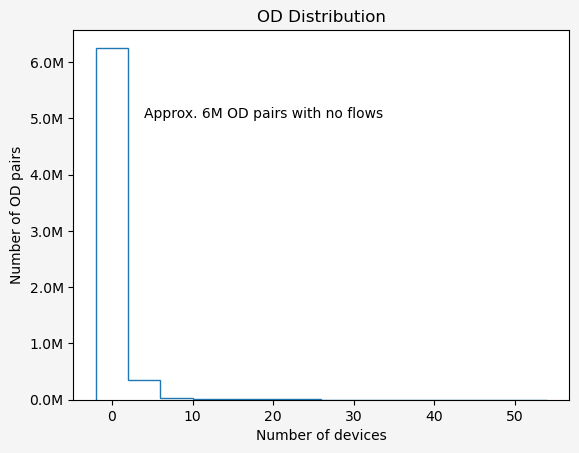

In [164]:
fig, axs = plt.subplots(nrows=  1, ncols = 1, facecolor = 'whitesmoke')
axs.stairs(counts, bins-2)
axs.yaxis.set_major_formatter(formatter)
axs.set_title("OD Distribution")
axs.set_ylabel("Number of OD pairs")
axs.set_xlabel("Number of devices")
axs.text(4, 5000000, s = "Approx. 6M OD pairxs with no flows")
plt.show()

Text(0.5, 1.0, 'Truncated OD Distribution')

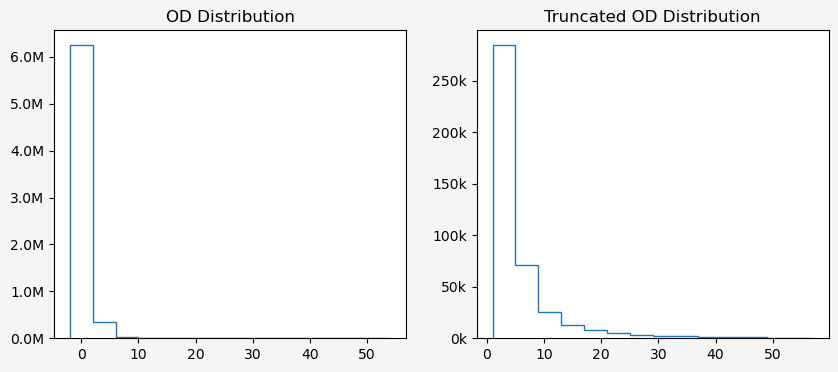

In [107]:
fig, axs = plt.subplots(nrows=  1, ncols = 2, figsize = (10,4), facecolor = 'whitesmoke')
axs[0].stairs(counts_0, bins_0-2)
axs[0].yaxis.set_major_formatter(formatter) 
axs[1].yaxis.set_major_formatter(formatter_2) 
axs[1].stairs(counts, bins)
axs[0].set_title("OD Distribution")
axs[1].set_title("Truncated OD Distribution")

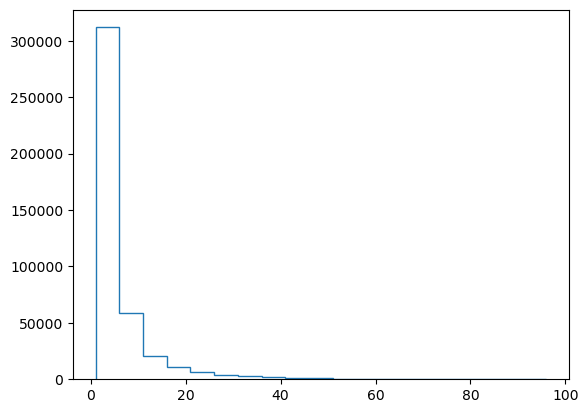

In [44]:


plt.stairs(counts, bins)

# Unsure what for

In [9]:
od_matrix_np = od_matrix.copy(deep=True)

In [10]:
od_matrix_np = od_matrix_np.to_numpy()
od_matrix_np_nodiag = od_matrix_np.copy()
np.fill_diagonal(od_matrix_np_nodiag, 0)

In [11]:
od_matrix_np_pct = od_matrix_np / np.max(od_matrix_np, axis = 0)
od_matrix_np_pct_nodiag = od_matrix_np_nodiag / np.max(od_matrix_np_nodiag, axis = 0)
od_matrix_np_pct_nodiag_singlemax = od_matrix_np_nodiag / np.max(od_matrix_np_nodiag)

/tmp/ipykernel_609608/3120664391.py:2: RuntimeWarning: invalid value encountered in divide
  od_matrix_np_pct_nodiag = od_matrix_np_nodiag / np.max(od_matrix_np_nodiag, axis = 0)


In [76]:
# New Haven
od_matrix.loc[[90091420002]]

,090010101011,090010101012,090010101013,090010101014,090010101021,090010101022,090010101023,090010102011,090010102012,090010102013,090010102021,090010102022,090010102023,090010102024,090010103001,090010103002,090010103003,090010103004,090010103005,090010104001,090010104002,090010104003,090010104004,090010104005,090010104006,090010105001,090010105002,090010105003,090010105004,090010105005,090010105006,090010106001,090010106002,090010106003,090010107001,090010107002,090010107003,090010107004,090010108001,090010108002,090010108003,090010108004,090010109001,090010109002,090010109003,090010109004,090010110001,090010110002,090010110003,090010110004,...,090159011004,090159011005,090159022001,090159025001,090159025002,090159025003,090159031001,090159031002,090159031003,090159031004,090159031005,090159031006,090159031007,090159031008,090159032001,090159032002,090159041001,090159041002,090159041003,090159041004,090159044001,090159044002,090159044003,090159044004,090159045001,090159045002,090159045003,090159045004,090159045005,090159051001,090159051002,090159051003,090159051004,090159051005,090159061001,090159061002,090159061003,090159071001,090159071002,090159071003,090159072001,090159072002,090159072003,090159072004,090159073001,090159073002,090159073003,090159073004,090159081001,090159081002
90091420002,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


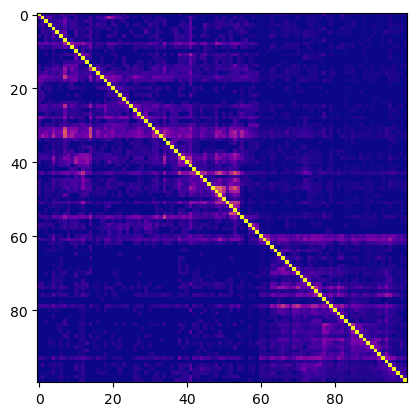

In [49]:
plt.imshow(od_matrix_np_pct[0:100, 0:100], vmin = 0, vmax = 1, cmap = 'plasma')

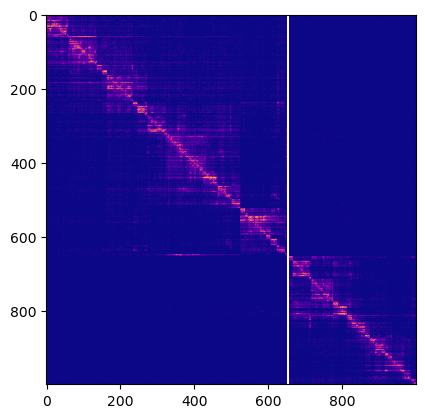

In [50]:
plt.imshow(od_matrix_np_pct_nodiag[0:1000, 0:1000], vmin = 0, vmax = 1, cmap = 'plasma')

In [35]:
np.unravel_index(np.argmax(od_matrix_np_pct_nodiag), od_matrix_np_pct_nodiag.shape)

(0, 653)

In [46]:
np.sum(od_matrix_np[:, 653])

7.0